@Author: Fantasy_Silence                           
@Time: 2024-05-28                                  
@IDE: Visual Studio Code & PyCharm                 
@Python: 3.9.7
@Description: 这里是主程序入口。                                     

In [17]:
# 导入相关库
import warnings
import matplotlib
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, cross_val_score

from src.common.filesio import FilesIO
from src.modules.process.vtsplit import TargetVaribleSplit
from src.modules.datapreperation.get_text import GetTextFromPng
from src.modules.datapreperation.screenshot import GetScreenshot
from src.modules.process.dataprocess import PipeLineForDataProcess

warnings.filterwarnings("ignore")
matplotlib.rcParams['font.family'] = 'SimHei'
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
# 从公众号上获取数据
# 获取时请使用电脑打开"上海期货交易原油期货sc2406月度结算参考价所在区间"的历史走势
GetScreenshot.save(is_save=True)
GetTextFromPng.saveTextIncsv(filename="data.csv")

数据获取成功


In [2]:
# 加载数据
row_data = pd.read_csv(FilesIO.getDataset("data.csv"))
row_data.head()

,time,"(720, +oo]","(700, 720]","(680, 700]","(660, 680]","(640, 660]","(620, 640]","(600, 620]","(580, 600]",(0 580]
0,2024-05-06 12:58:44,0.111,0.111,0.111,0.111,0.111,0.111,0.111,0.111,0.111
1,2024-05-06 12:58:44,0.104,0.104,0.104,0.104,0.104,0.171,0.104,0.104,0.104
2,2024-05-06 12:59:41,0.080,0.080,0.080,0.080,0.080,0.359,0.080,0.080,0.080
3,2024-05-06 13:00:02,0.065,0.065,0.065,0.065,0.065,0.480,0.065,0.065,0.065
4,2024-05-06 18:59:41,0.058,0.058,0.058,0.058,0.058,0.438,0.058,0.058,0.157


In [6]:
# 处理数据
pipe = Pipeline([
    # 特征工程
    ("preprocess", PipeLineForDataProcess()),
    # 分离自变量与目标值
    ("split", TargetVaribleSplit(
        ['year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'is_weekend']
    )),
])
# 划分训练集
X_train, X_test, y_train, y_test = train_test_split(
    *pipe.transform(row_data), test_size=0.2, random_state=42
)

Tree: -0.002228 (0.000800)
LR: -0.004999 (0.001343)
RF: -0.001493 (0.000479)
KNN: -0.003625 (0.000977)


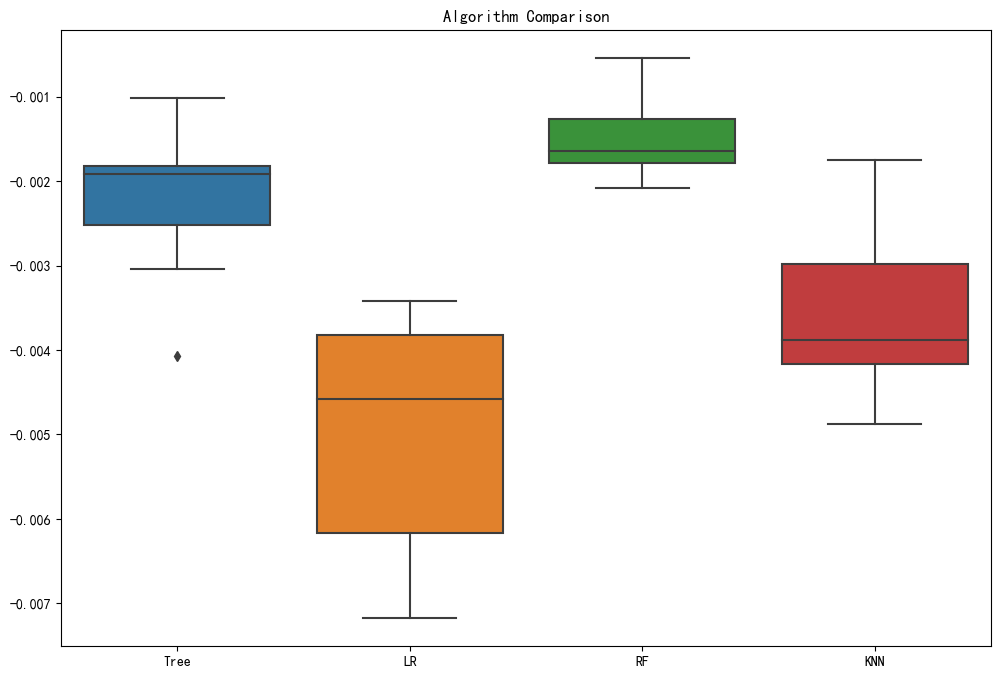

In [12]:
# 选取最佳的模型进行进一步预测
models = []
models.append(("Tree", DecisionTreeRegressor()))
models.append(("LR", LinearRegression()))
models.append(("RF", RandomForestRegressor()))
models.append(("KNN", KNeighborsRegressor()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(
        model, X_train, y_train, cv=kfold, scoring="neg_mean_squared_error"
    )
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
sns.boxplot(results, ax=ax)
ax.set_title('Algorithm Comparison')
ax.set_xticklabels(names)
plt.show()

In [15]:
# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
selected_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=selected_model, param_grid=param_grid,
    cv=5, n_jobs=-1, scoring='neg_mean_squared_error',
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [18]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("MSE", mean_squared_error(y_test, y_pred))

MSE 0.0013271330447325134


In [19]:
# 获取最新的时间戳
last_time = row_data['time'].max()
# 预测下一个时刻
next_time = last_time + timedelta(minutes=1)
# 提取时间特征
next_time_features = {
    'year': next_time.year,
    'month': next_time.month,
    'day': next_time.day,
    'hour': next_time.hour,
    'minute': next_time.minute,
    'day_of_week': next_time.weekday(),
    'is_weekend': 1 if next_time.weekday() >= 5 else 0
}

# 进行预测
next_time_df = pd.DataFrame([next_time_features])
next_time_prediction = best_model.predict(next_time_df)

# 创建包含预测结果的DataFrame
prediction_df = pd.DataFrame(next_time_prediction, columns=y_train.columns)
prediction_df

,"(720, +oo]","(700, 720]","(680, 700]","(660, 680]","(640, 660]","(620, 640]","(600, 620]","(580, 600]",(0 580]
0,0.004866,0.004866,0.126142,0.004866,0.001796,0.118418,0.733599,0.002444,0.002444
